**Подключение библиотек и скриптов**

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# вспомогательные ф-ции

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

#### загрузка данных

In [5]:
train_path = './input/course_project_train.csv'
test_path = './input/course_project_test.csv'

In [6]:
# целевая переменная
target_name = 'Credit Default'

In [7]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

#### обзор данных

In [8]:
train_df.shape

(7500, 17)

In [9]:
test_df.shape

(2500, 16)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

In [12]:
for col_name in train_df.select_dtypes(include='object').columns:
    print(str(col_name)+'   \n'+str(train_df[col_name].value_counts()))
    print('-' * 80)

Home Ownership   
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
--------------------------------------------------------------------------------
Years in current job   
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
--------------------------------------------------------------------------------
Purpose   
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy 

In [13]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


#### разбиение датасета

In [14]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)

#### обработка пропусков и выбросов

In [15]:
def prepare_df(df, X_train=X_train, y_train=y_train):
    tmp_df = pd.concat([X_train, y_train], axis=1)
    cs_target_1 = tmp_df.loc[(tmp_df['Credit Score'] < 4000) & (
        tmp_df['Credit Default'] == 1), 'Credit Score'].median()
    cla_target_0 = tmp_df.loc[(tmp_df['Current Loan Amount'] < 1e6) & (
        tmp_df['Credit Default'] == 0), 'Current Loan Amount'].median()

    df.loc[df.loc[df['Credit Score'] > 4000].index, 'Credit Score high'] = 1
    df['Credit Score high'] = df['Credit Score high'].fillna(0)
    df.loc[df['Credit Score'] > 4000, 'Credit Score'] = cs_target_1

    df.loc[df['Credit Score'].isna(), 'Credit Score'] = X_train.loc[
        X_train['Credit Score'] < 4000, 'Credit Score'].mean()

    df.loc[df.loc[
        df['Current Loan Amount'] > 1e6].index, 'Current Loan Amount high'] = 1
    df['Current Loan Amount high'] = df['Current Loan Amount high'].fillna(0)
    df.loc[df['Current Loan Amount'] > 1e6,
           'Current Loan Amount'] = cla_target_0

    df.loc[df['Bankruptcies'].isna(
    ), 'Bankruptcies'] = X_train['Bankruptcies'].median()

    df.loc[df['Home Ownership'].isna(
    ), 'Home Ownership'] = X_train['Home Ownership'].mode()[0]

    df.loc[df['Years in current job'].isna(
    ), 'Years in current job'] = X_train['Years in current job'].mode()[0]

    df.loc[df['Months since last delinquent'].isna(
    ), 'Months since last delinquent'] = X_train[
        'Months since last delinquent'].median()

    df.loc[df['Annual Income'].isna(
    ), 'Annual Income'] = X_train['Annual Income'].mean()

In [16]:
prepare_df(X_train)
prepare_df(X_test)
prepare_df(test_df)

In [17]:
def make_cat_features(df):
    df['Home Ownership_new'] = df['Home Ownership'].map({
        'Home Mortgage': 1,
        'Have Mortgage': 1,
        'Rent': 2,
        'Own Home': 3
    }).astype(int)
    
    df['Years in current job_new'] = df['Years in current job'].map({
        '< 1 year': 0,
        '1 year': 1,
        '2 years': 2,
        '3 years': 3,
        '4 years': 4,
        '5 years': 5,
        '6 years': 6,
        '7 years': 7,
        '8 years': 8,
        '9 years': 9,
        '10+ years': 10
    }).astype(int)

    df['Purpose_new'] = df['Purpose'].map({
        'debt consolidation': 0,
        'other': 1,
        'home improvements': 2,
        'business loan': 3,
        'buy a car': 4,
        'medical bills': 5,
        'major purchase': 6,
        'take a trip': 7,
        'buy house': 8,
        'small business': 9,
        'wedding': 10,
        'moving': 11,
        'educational expenses': 12,
        'vacation': 13,
        'renewable energy': 14
    }).astype(int)  

In [18]:
make_cat_features(X_train)
make_cat_features(X_test)
make_cat_features(test_df)

In [19]:
# оставим только нужные признаки
X_train = X_train.select_dtypes(exclude=object)
X_test = X_test.select_dtypes(exclude=object)
test_df = test_df.select_dtypes(exclude=object)

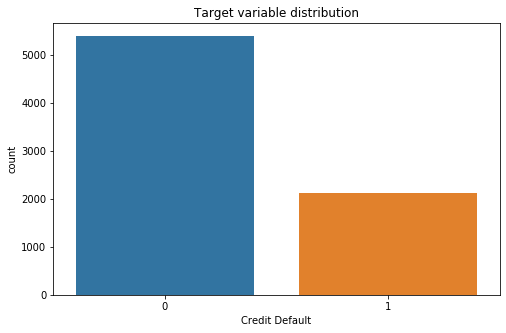

In [20]:
# несбалансированная выборка
plt.figure(figsize=(8, 5))

sns.countplot(x=target_name, data=train_df)

plt.title('Target variable distribution')
plt.show()

In [21]:
# несбалансированная выборка
y_train.value_counts(normalize=True)

0    0.722857
1    0.277143
Name: Credit Default, dtype: float64

In [22]:
# этот коэффициент будем использовать в финаьлной модели, для учета несбалансированности
0.718267 / 0.281733

2.5494599496686576

In [23]:
# список с именами фич
feature_names = X_train.columns.tolist()

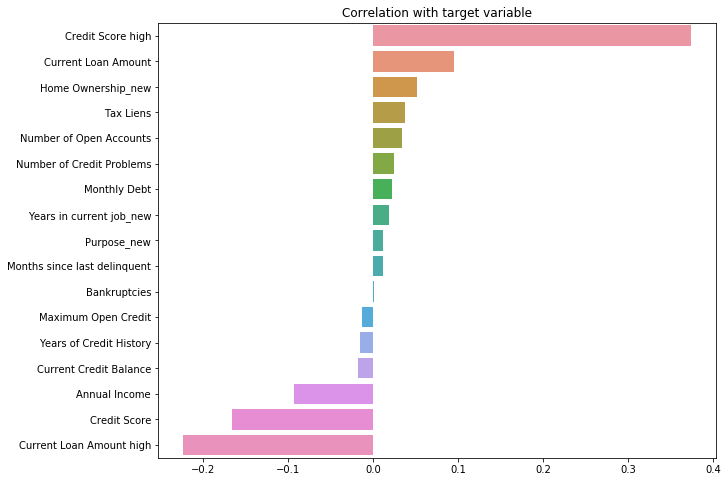

In [24]:
# корреляция признаков с целевой переменной
corr_with_target = pd.concat([X_train, y_train], axis=1).corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

#### удаление ненужных признаков

In [25]:
features_to_drop = ['Bankruptcies']

In [26]:
X_train.drop(columns=features_to_drop, axis=1, inplace=True)
X_test.drop(columns=features_to_drop, axis=1, inplace=True)
test_df.drop(columns=features_to_drop, axis=1, inplace=True)

#### финальная модель 

In [27]:
model_catb = catb.CatBoostClassifier(silent=True,
                                     random_state=21,
                                     scale_pos_weight=2.55,
                                     n_estimators=400,
                                     max_depth=3,
                                     l2_leaf_reg=10)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

             precision    recall  f1-score   support

          0       0.87      0.72      0.79      3795
          1       0.50      0.73      0.59      1455

avg / total       0.77      0.72      0.73      5250

TEST

             precision    recall  f1-score   support

          0       0.83      0.68      0.75      1592
          1       0.46      0.67      0.55       658

avg / total       0.72      0.68      0.69      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1079  513
1                216  442


#### прогнозирование целевой переменной

In [28]:
predictions = model_catb.predict(test_df)
predictions_df = pd.DataFrame({target_name: predictions}, dtype=np.int)
predictions_df.to_csv('./output/OSapegin_predictions.csv', index=False)